<h2 style="text-align: center; font-size: 48px;">HEART DISEASE PREDICTION</h2>
<h1 style="text-align: center; font-size: 16px">Given clinical parameters about a patient, can we predict whether or not they have heart disease?</h1>


# Data
The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https://www.kaggle.com/datasets/sumaiyatasmeem/heart-disease-classification-dataset

# Evaluation
If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

# Features
* **age** - age in years
* **sex** - (1 = male; 0 = female)
* **cp** - chest pain type:
  1. Typical angina: chest pain related to decreased blood supply to the heart
  2. Atypical angina: chest pain not related to the heart
  3. Non-anginal pain: typically esophageal spasms (non-heart related)
  4. Asymptomatic: chest pain not showing signs of disease
* **trestbps** - resting blood pressure (in mm Hg on admission to the hospital); anything above 130-140 is typically a cause for concern
* **chol** - serum cholesterol in mg/dl:
  - serum = LDL + HDL + 0.2 * triglycerides
  - above 200 is a cause for concern
* **fbs** - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false):
  - '>126' mg/dL signals diabetes
* **restecg** - resting electrocardiographic results:
  1. Nothing to note
  2. ST-T Wave abnormality: can range from mild symptoms to severe problems; signals non-normal heartbeat
  3. Possible or definite left ventricular hypertrophy: Enlarged heart's main pumping chamber
* **thalach** - maximum heart rate achieved
* **exang** - exercise induced angina (1 = yes; 0 = no)
* **oldpeak** - ST depression induced by exercise relative to rest; looks at stress of the heart during exercise; unhealthy heart will stress more
* **slope** - the slope of the peak exercise ST segment:
  1. Upsloping: better heart rate with exercise (uncommon)
  2. Flatsloping: minimal change (typical healthy heart)
  3. Downsloping: signs of an unhealthy heart
* **ca** - number of major vessels (0-3) colored by fluoroscopy:
  - colored vessel means the doctor can see the blood passing through
  - the more blood movement, the better (no clots)
* **thal** - thallium stress result:
  1. 1,3: normal
  2. 6: fixed defect: used to be a defect but okay now
  3. 7: reversible defect: no proper blood movement when exercising
* **target** - have disease or not (1 = yes, 0 = no) (the predicted attribute)

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, RocCurveDisplay

In [34]:
df = pd.read_csv('heart-disease.csv')

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
df.shape

(303, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [10]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [152]:
df['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

In [28]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


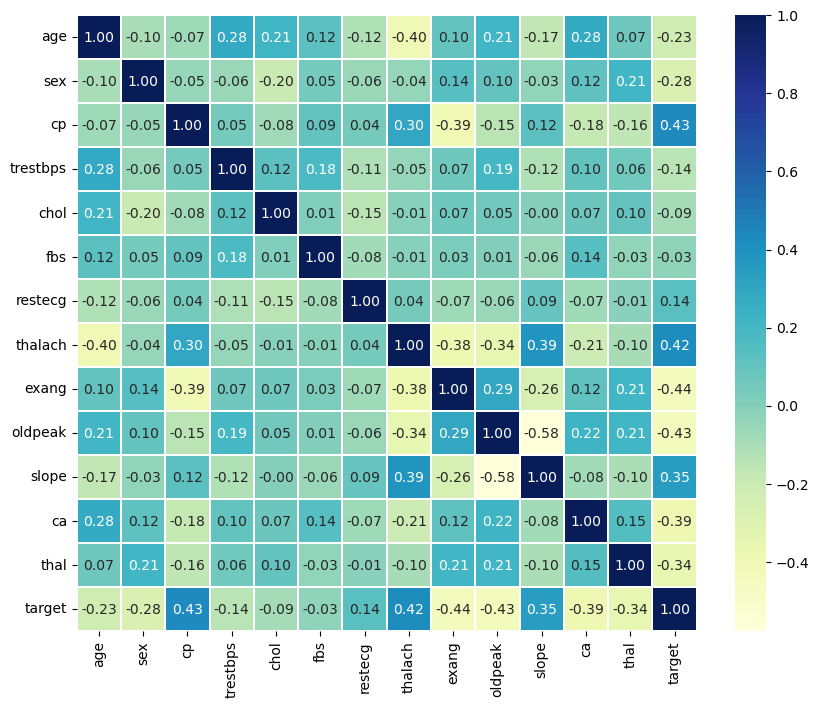

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='YlGnBu',annot=True, fmt='.2f', linewidths=0.3);

In [25]:
df['sex'].value_counts()

sex
1    207
0     96
Name: count, dtype: int64

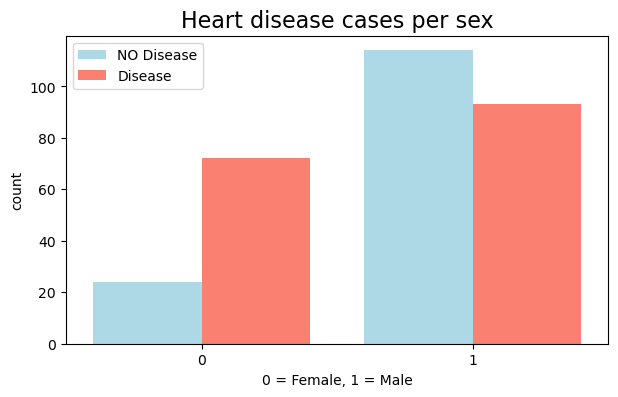

In [118]:
plt.figure(figsize=(7,4), dpi=100)
sns.countplot(data=df, x='sex', hue='target', palette=['lightblue','salmon'], saturation=1)

plt.title('Heart disease cases per sex', fontsize=16)
plt.xlabel('0 = Female, 1 = Male')
plt.legend(['NO Disease', 'Disease']);

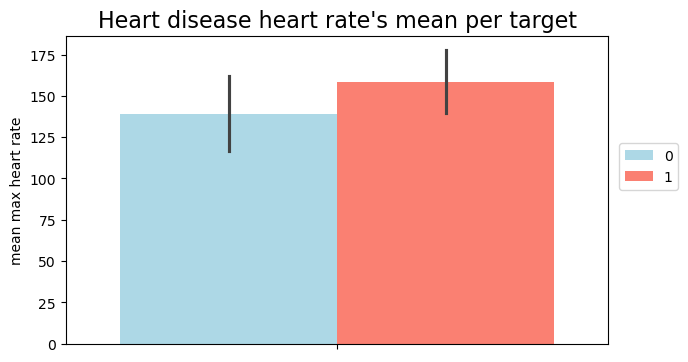

In [119]:
plt.figure(figsize=(7,4), dpi=100)
sns.barplot(data=df, hue='target', y='thalach', estimator=np.mean, errorbar='sd', palette=['lightblue','salmon'], saturation=1)

plt.title("Heart disease heart rate's mean per target", fontsize=16)
plt.ylabel('mean max heart rate')
plt.legend(loc=(1.02,0.5));

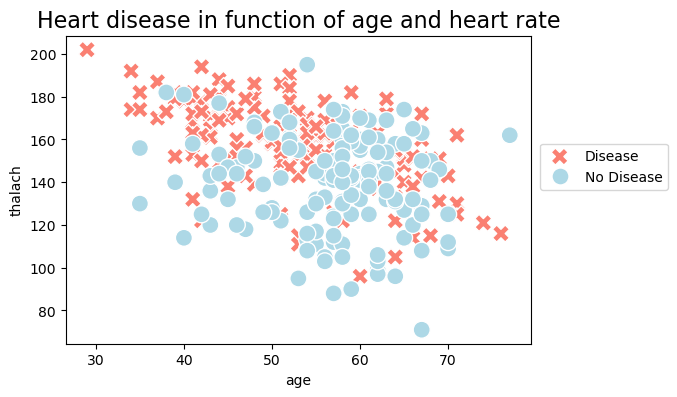

In [120]:
plt.figure(figsize=(6,4), dpi=100)
sns.scatterplot(x=df['age'], y=df['thalach'], data=df, hue='target', style='target', s=150, palette=['lightblue','salmon'])

plt.title('Heart disease in function of age and heart rate', fontsize=16)
plt.legend(['Disease', 'No Disease'], loc=(1.02,0.5));

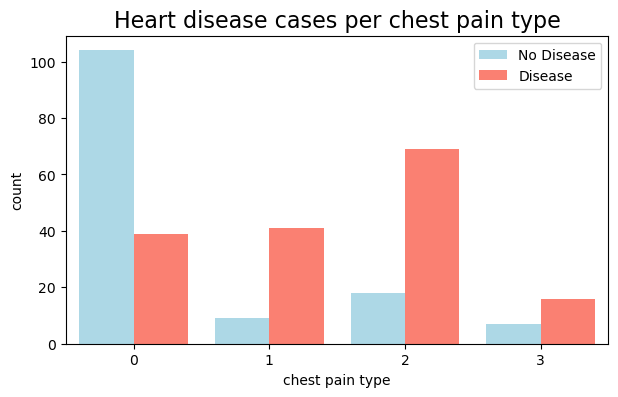

In [286]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='cp', hue='target', palette=['lightblue','salmon'], saturation=1)

plt.title('Heart disease cases per chest pain type', fontsize=16)
plt.xlabel('chest pain type')
plt.legend(['No Disease', 'Disease']);

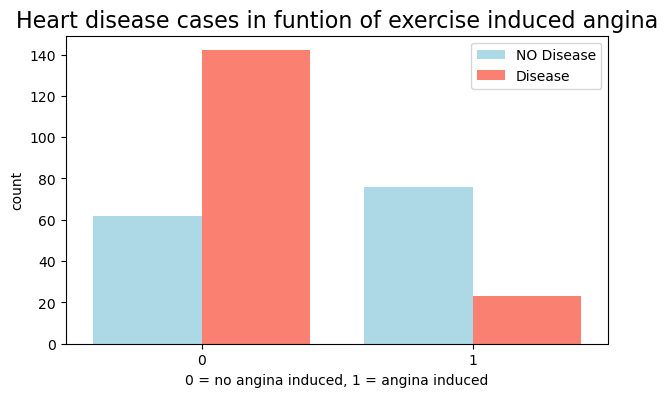

In [122]:
plt.figure(figsize=(7,4), dpi=100)
sns.countplot(data=df, x='exang', hue='target', palette=['lightblue','salmon'], saturation=1)

plt.title('Heart disease cases in funtion of exercise induced angina', fontsize=16)
plt.xlabel('0 = no angina induced, 1 = angina induced')
plt.legend(['NO Disease', 'Disease']);

# Modelling

In [196]:
X = df.drop('target', axis = 1)
y = df['target']

In [197]:
np.random.seed(111)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [198]:
models = {'Logist Regression': LogisticRegression(),
         'KNN': KNeighborsClassifier(),
         'Random Forest': RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(111)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [199]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_scores = fit_and_score(models, X_train_scaled, X_test_scaled, y_train, y_test)

model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare

,Logist Regression,KNN,Random Forest
accuracy,0.885246,0.754098,0.836066


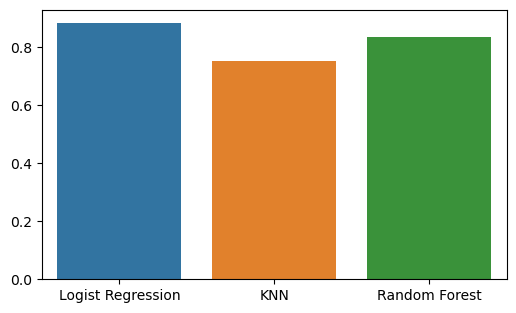

In [200]:
plt.figure(figsize=(6, 3.5))
sns.barplot(data=model_compare)
plt.xticks(rotation=0);

# Tuning

In [171]:
train_scores = []
test_scores = []

neighbors = range(1,21)

knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

Maximum KNN score on the test data: 88.52% at k=15


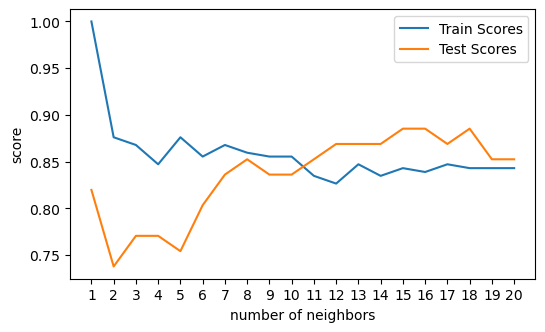

In [172]:
plt.figure(figsize=(6, 3.5))
plt.plot(neighbors, train_scores, label='Train Scores')
plt.plot(neighbors, test_scores, label='Test Scores')
plt.xlabel('number of neighbors')
plt.xticks(np.arange(1,21,1))
plt.ylabel('score')
plt.legend();

print(f'Maximum KNN score on the test data: {max(test_scores)*100:.2F}% at k={test_scores.index(max(test_scores)) + 1}')

In [192]:
knn.set_params(n_neighbors=15)
knn.fit(X_train_scaled, y_train)

knn_score = knn.score(X_test_scaled, y_test)
knn_score

0.8852459016393442

In [155]:
grid_lr = {'C': np.logspace(-4, 4, 20),
           'solver': ['liblinear']}

grid_rf = {'n_estimators': np.arange(10, 1000, 50),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2)}

In [185]:
np.random.seed(111)

rs_lr = RandomizedSearchCV(LogisticRegression(), param_distributions=grid_lr, cv=5, n_iter=20, verbose=True)

rs_lr.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [186]:
rs_lr.best_params_

{'solver': 'liblinear', 'C': 0.1082636733874054}

In [187]:
log_regression_score = rs_lr.score(X_test_scaled, y_test)
log_regression_score

0.9016393442622951

In [188]:
np.random.seed(111)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=grid_rf, cv=5, n_iter=20, verbose=True)

rs_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [189]:
rs_rf.best_params_

{'n_estimators': 660,
 'min_samples_split': 6,
 'min_samples_leaf': 11,
 'max_depth': None}

In [190]:
random_forest_score = rs_rf.score(X_test_scaled, y_test)
random_forest_score

0.8524590163934426

In [179]:
grid_lr = {'C': np.logspace(-4, 4, 30),
           'solver': ['liblinear']}

gs_lr = GridSearchCV(LogisticRegression(), grid_lr, cv=5, verbose=True)

gs_lr.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [180]:
gs_lr.best_params_

{'C': 0.1082636733874054, 'solver': 'liblinear'}

In [191]:
log_regression_score = gs_lr.score(X_test_scaled, y_test)
log_regression_score

0.9016393442622951

In [194]:
model_scores

{'Logist Regression': 0.8852459016393442,
 'KNN': 0.7540983606557377,
 'Random Forest': 0.8360655737704918}

In [206]:
models_score_final = {'Logist Regression': log_regression_score,
                      'KNN': knn_score,
                      'Random Forest': random_forest_score}

model_compare_final = pd.DataFrame(models_score_final, index=['accuracy'])
model_compare_final

,Logist Regression,KNN,Random Forest
accuracy,0.901639,0.885246,0.852459


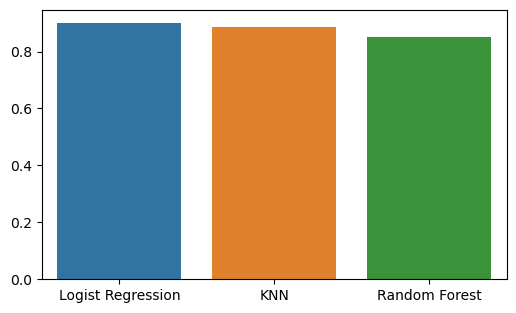

In [207]:
plt.figure(figsize=(6, 3.5))
sns.barplot(data=model_compare_final)
plt.xticks(rotation=0);

In [273]:
scores_improved = model_compare.merge(model_compare_final, how='outer').T
scores_improved.columns = ['first', 'post_tuning']

scores_improved

,first,post_tuning
Logist Regression,0.885246,0.901639
KNN,0.754098,0.885246
Random Forest,0.836066,0.852459


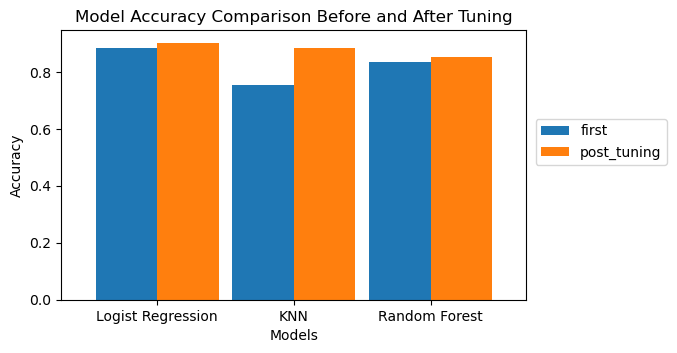

In [289]:
scores_improved.plot.bar(figsize=(6, 3.5), width=0.9)
plt.title('Model Accuracy Comparison Before and After Tuning')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend(loc=(1.02,0.5));

# Evaluating

In [302]:
y_preds = gs_lr.predict(X_test_scaled)
y_preds

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1])

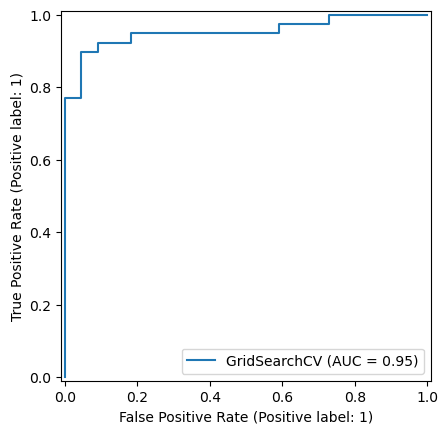

In [306]:
RocCurveDisplay.from_estimator(gs_lr, X_test_scaled, y_test);

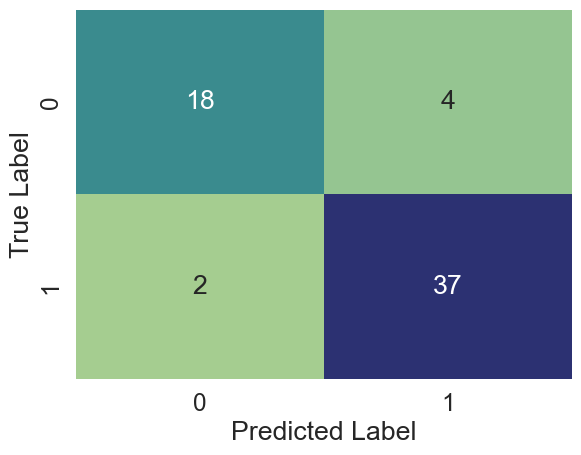

In [311]:
sns.set(font_scale=1.6)
conf_map = confusion_matrix(y_test, y_preds)
sns.heatmap(conf_map, cmap='crest', cbar=False, annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

* true positives = 37, the model predict 1 when value was 1
* true negatives = 18, the model predict 0 when value was 0

* false positives = 4, the model predict 1 when value was 0
* false negatives = 2, the model predict 0 when value was 1

In [320]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        22
           1       0.90      0.95      0.93        39

    accuracy                           0.90        61
   macro avg       0.90      0.88      0.89        61
weighted avg       0.90      0.90      0.90        61



In [322]:
gs_lr.best_params_

{'C': 0.1082636733874054, 'solver': 'liblinear'}

In [326]:
clf = LogisticRegression(C=0.1082636733874054, solver='liblinear')
X = scaler.fit_transform(X)

In [330]:
cv_accuracy = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
cv_accuracy = np.mean(cv_accuracy)
cv_accuracy

0.831584699453552

In [331]:
cv_precision = cross_val_score(clf, X, y, cv=5, scoring='precision')
cv_precision = np.mean(cv_precision)
cv_precision

0.8155450802509627

In [332]:
cv_recall = cross_val_score(clf, X, y, cv=5, scoring='recall')
cv_recall = np.mean(cv_recall)
cv_recall

0.8969696969696971

In [333]:
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring='f1')
cv_f1 = np.mean(cv_f1)
cv_f1

0.8533074885313692

In [343]:
cv_metrics = pd.DataFrame({'Accuracy': cv_accuracy,
                           'Precision': cv_precision,
                           'Recall': cv_recall,
                           'f1': cv_f1},
                          index=['score'])

In [344]:
cv_metrics

,Accuracy,Precision,Recall,f1
score,0.831585,0.815545,0.89697,0.853307


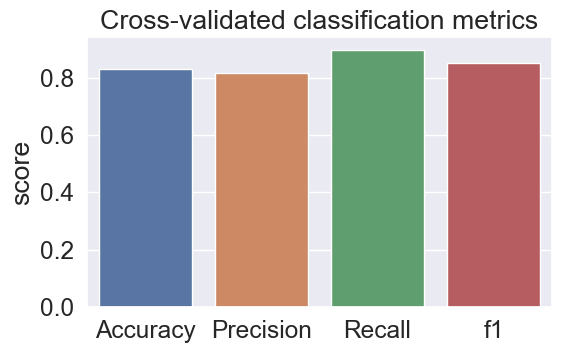

In [347]:
plt.figure(figsize=(6, 3.5))
sns.barplot(data=cv_metrics)
plt.title('Cross-validated classification metrics')
plt.ylabel('score')
plt.xticks(rotation=0);

# Important feature

In [349]:
clf.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1082636733874054, solver='liblinear')

In [350]:
clf.coef_

array([[-0.05340682, -0.54546034,  0.56574535, -0.20884278, -0.14758422,
        -0.02122717,  0.14386943,  0.35540819, -0.40530373, -0.3820844 ,
         0.25149474, -0.59698005, -0.45772853]])

In [351]:
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': -0.05340682103025305,
 'sex': -0.545460339539165,
 'cp': 0.5657453539677689,
 'trestbps': -0.20884278275697032,
 'chol': -0.14758421717917242,
 'fbs': -0.02122717165988887,
 'restecg': 0.14386943489929993,
 'thalach': 0.3554081891393464,
 'exang': -0.4053037260886211,
 'oldpeak': -0.38208440116182135,
 'slope': 0.25149473885233764,
 'ca': -0.5969800502616249,
 'thal': -0.45772853117226675}

In [352]:
feature_df = pd.DataFrame(feature_dict, index=[0])

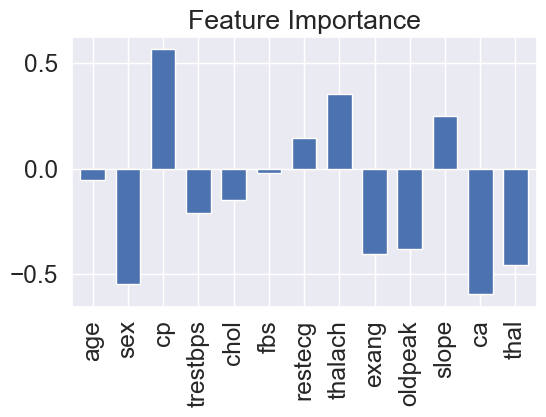

In [361]:
feature_df.T.plot.bar(figsize=(6, 3.5), width=0.7, title='Feature Importance', legend=False);